# Predicting IV with surrogate

We propose two surrogates, Heston model ('heston') and 'Bates with double jump'

In [4]:
from matplotlib import pyplot as plt
from matplotlib import cm
from source.deepsurrogate import *
from scipy.interpolate import griddata

model_name = 'heston'
model_name = 'bdjm' # comment this out to load the heston surrogate

We load a simualted day with random parameters, some random options with their IV computed with the "true" model through the popular library QuantLib

In [5]:
df = pd.read_csv(f'dat/{model_name}_ex.csv',index_col=False)

### load the surrogate model

In [7]:
surogate = DeepSurrogate(model_name)

Use the surrogate to get the models' iv 

In [8]:
df['surrogate_iv']=surogate.get_iv(df)

### Visualisation, comparing the "true" and surrogate IV-surface

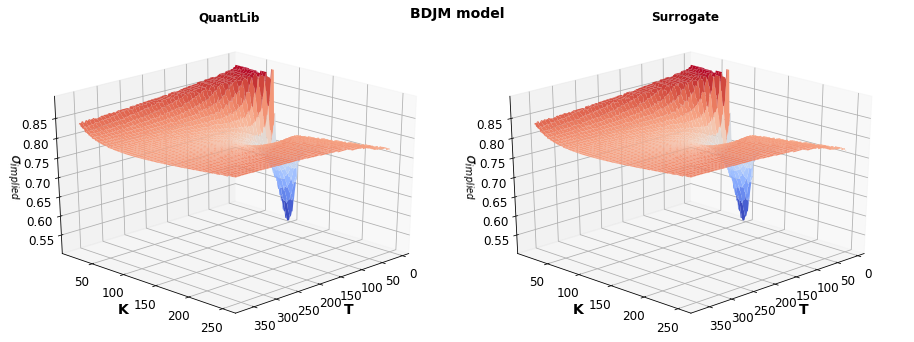

In [18]:
    def make_surf_plot(X, Y, Z, ax):
        """
        Create a volatility surface plot
        """
        XX, YY = np.meshgrid(np.linspace(min(X), max(X), 230), np.linspace(min(Y), max(Y), 230))
        ZZ = griddata(np.array([X, Y]).T, np.array(Z), (XX, YY), method='nearest')

        ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm, linewidth=0)
        ax.view_init(25, 45)
        ax.set_xlabel('T')
        ax.set_ylabel('K')
        ax.set_zlabel(r'$\sigma_{implied}$')
        plt.tight_layout()
        return fig, ax


    fig = plt.figure(figsize=[6.4 * 2, 4.8])
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    fig, ax = make_surf_plot(df['T'], df['strike'], df['original_iv'], ax)
    ax.set_title("QuantLib", fontsize=12, fontweight='bold')
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    fig, ax = make_surf_plot(df['T'], df['strike'], df['surrogate_iv'], ax)
    ax.set_title("Surrogate", fontsize=12, fontweight='bold')
    t = fig.suptitle(f"{model_name.upper()} model", fontsize=14, fontweight='bold')
    
    plt.show()

# Getting the derrivative per parameters
One of the advantage of the surrogate technology is that you can get the model's gradient for "free"

In [20]:
d = surogate.get_iv_delta(df)

We get the gradient for each input and each row

In [22]:
print(d.head())

      kappa     theta     sigma       rho  lambda_parameter      nuUp    nuDown         p        v0    strike         T        rf  dividend
0  0.020578  0.203624 -0.009468  0.004478          0.093000  0.085659  0.038203  0.036148  0.009069  0.000439  0.011628 -0.000034  0.000011
1 -0.006107  0.168870  0.022511 -0.011167          0.081900  0.033766  0.086655 -0.012185  0.007928 -0.057955 -0.022888  0.000993 -0.000687
2  0.009672  0.020242  0.011906 -0.004478          0.097091  0.004773  0.124582 -0.062409  0.025608 -0.400614 -1.251409  0.001292 -0.000797
3  0.039763  0.105503 -0.018073  0.014601          0.113215  0.160276  0.010708  0.098816  0.024535  0.064841 -0.052944 -0.001654  0.001112
4  0.059550  0.166130 -0.022913  0.012987          0.093873  0.097034  0.020362  0.058233  0.037682  0.026595  0.113234 -0.000591  0.000372


### Visualsation - derrivative surface

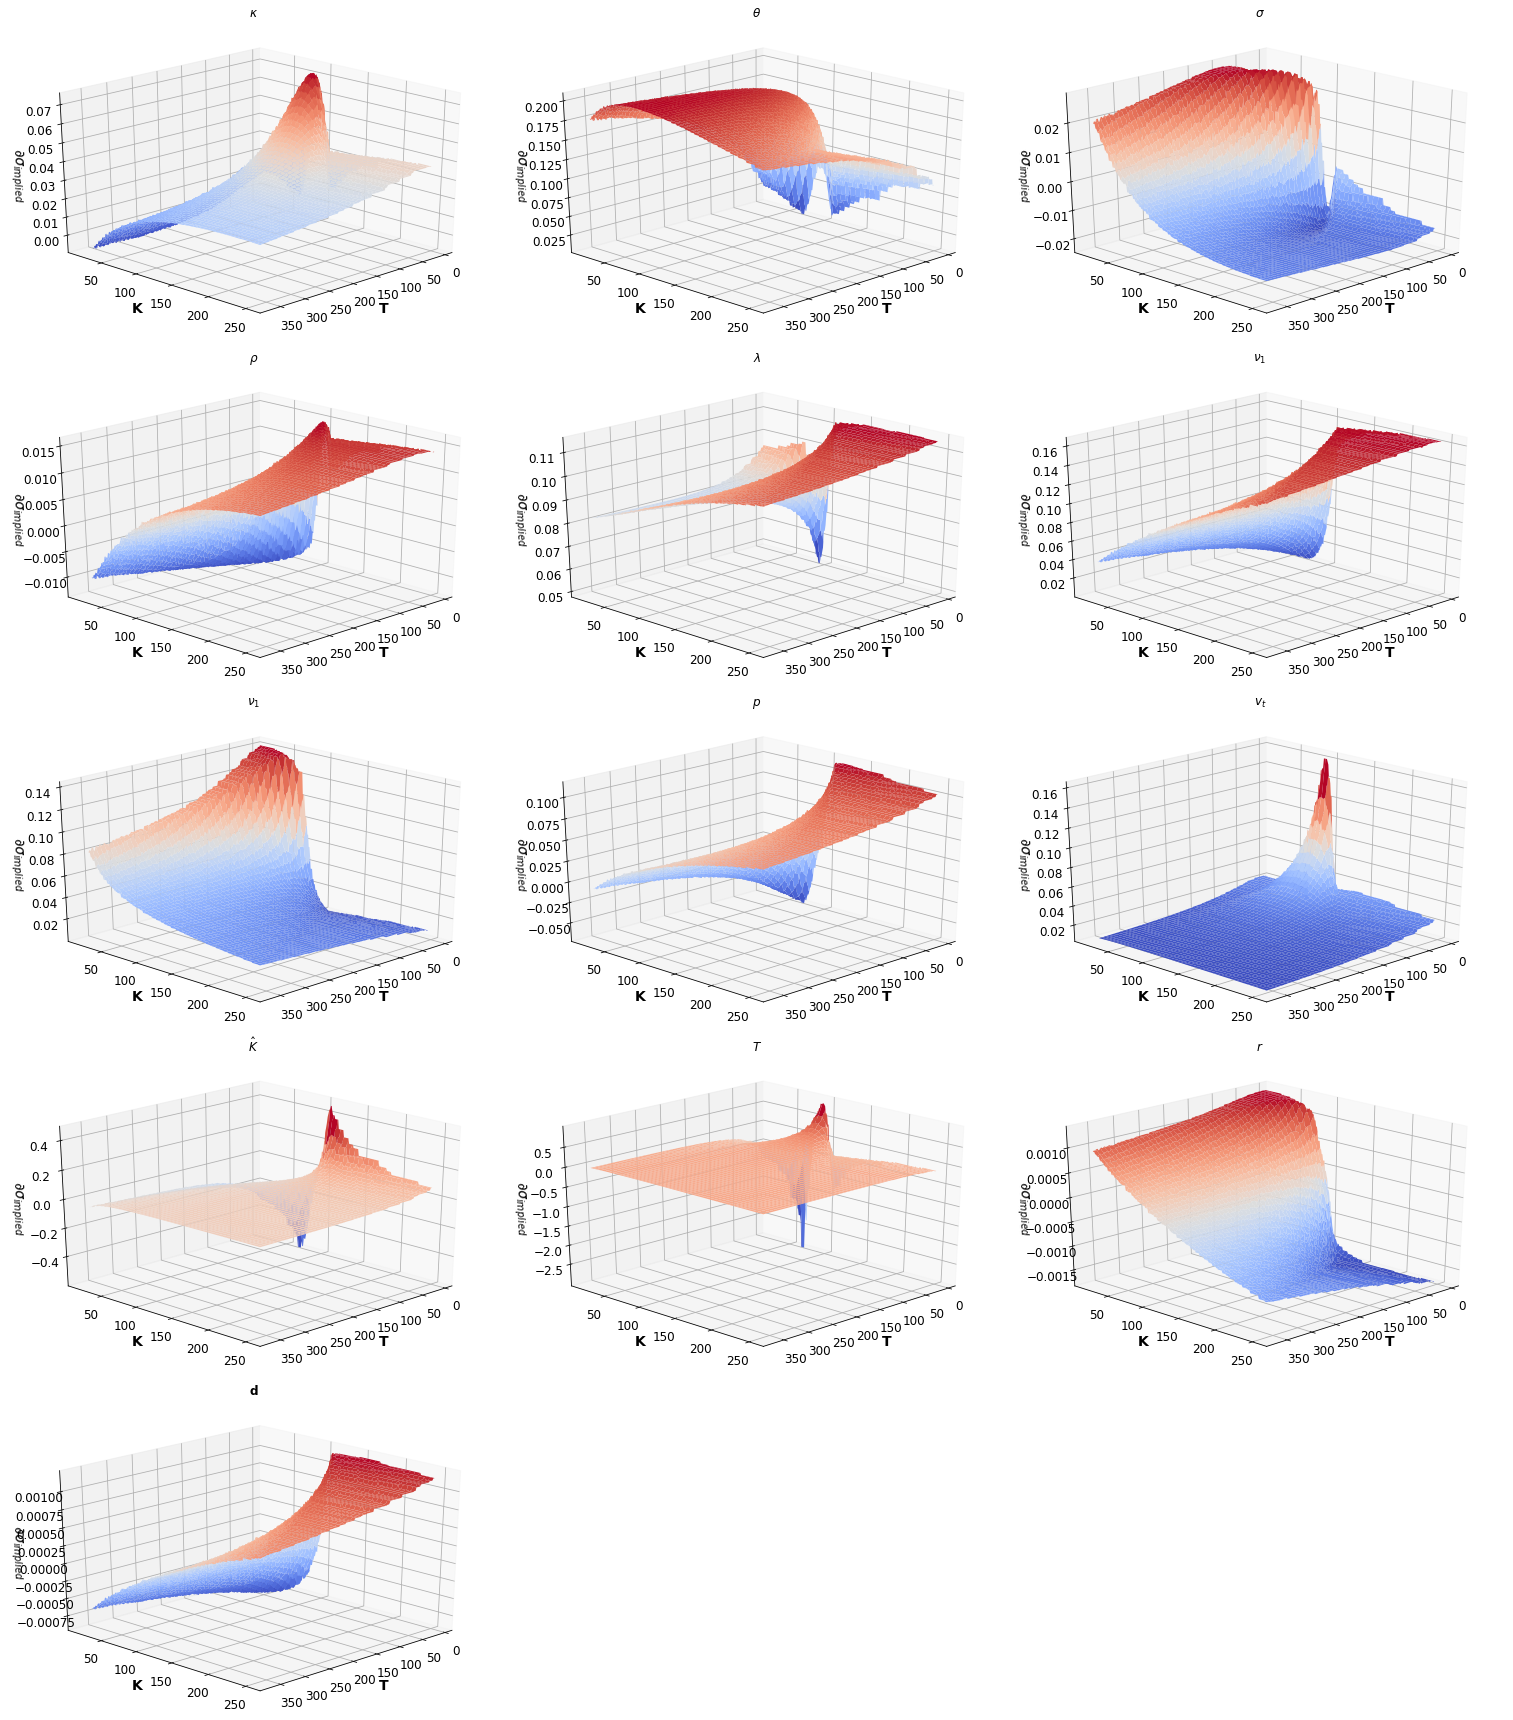

In [30]:
def make_surf_plot(X,Y,Z,ax):
    XX,YY = np.meshgrid(np.linspace(min(X),max(X),230),np.linspace(min(Y),max(Y),230))
    ZZ = griddata(np.array([X,Y]).T,np.array(Z),(XX,YY), method='nearest')

    ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,linewidth=0)
    ax.view_init(25, 45)
    ax.set_xlabel('T')
    ax.set_ylabel('K')
    ax.set_zlabel(r'$\partial \sigma_{implied}$')
    plt.tight_layout()
    return fig,ax

nb_col = 3
nb_row = int(np.ceil(d.shape[1] / nb_col))

fig = plt.figure(figsize=[6.4 * nb_col*1.1, 4.8*nb_row])

dict_tr = {'kappa': r'$\kappa$', 'theta': r'$\theta$', 'sigma': r'$\sigma$', 'rho': r'$\rho$', 'lambda_parameter': r'$\lambda$', 'nuUp': r'$\nu_1$',
            'nuDown': r'$\nu_1$', 'p': r'$p$', 'v0': r'$v_t$', 'strike': r'$\hat{K}$', 'T': r'$T$', 'rf': r'$r$', 'dividend': 'd'}

for i in range(d.shape[1]):
    ax = fig.add_subplot(nb_row, nb_col, i + 1, projection='3d')
    fig,ax = make_surf_plot(df['T'], df['strike'], d.iloc[:,i],ax)
    ax.set_title(dict_tr[d.columns[i]], fontsize=12, fontweight='bold')
plt.show()